## 0. Load Data & Data understanding
- get an understanding of the data
- create dataframes for later use

In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_X = pd.read_csv("data\data_X.csv", engine='python', sep=',', encoding='utf8')
df_Y = pd.read_csv("data\data_Y.csv", engine='python', sep=',', encoding='utf8')

In [3]:
df_X.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


### X values
- `date_time`: YYYY-MM-dd (every minute)
- `T_data_x_x`: 5 chambers each 3 sensors
- `H_data`: height
- `AH_data`: moisture content (probably in percent)

In [4]:
df_Y.head()

,date_time,quality
0,1/4/2015 0:05,392
1,1/4/2015 2:05,393
2,1/4/2015 4:05,400
3,1/4/2015 6:05,408
4,1/4/2015 8:05,405


### Y values
- `date_time`: MM/dd/YYYY (every 2 hours)
- `quality`: manual quality measurements

## 1. Data pre-processing
1.1. convert `date_time` to correct format

In [5]:
# 1. convert date_time
df_X['date_time'] = pd.to_datetime(df_X['date_time'])
df_Y['date_time'] = pd.to_datetime(df_Y['date_time'])

print(df_Y.loc[df_Y['date_time'] == '2015-01-04 00:05:00'])
print(df_X.loc[df_X['date_time'] == '2015-01-04 00:05:00'])

            date_time  quality
0 2015-01-04 00:05:00      392
               date_time  T_data_1_1  T_data_1_2  T_data_1_3  T_data_2_1  \
4325 2015-01-04 00:05:00         277         326         273         322   

      T_data_2_2  T_data_2_3  T_data_3_1  T_data_3_2  T_data_3_3  T_data_4_1  \
4325         335         352         505         501         670         326   

      T_data_4_2  T_data_4_3  T_data_5_1  T_data_5_2  T_data_5_3  H_data  \
4325         379         337         231         236         242  153.77   

      AH_data  
4325      7.9  


2.1 merge dataframes on `date_time`<br>
- - **option 1: simple merge and drop x values when dont match**
- - **?? option 2 ??: aggregate x values 2-hourly -> calculate the average** (not sure if this is allowed / makes sense)
- - the merged dataframe should have same length as `data_Y`, because otherwise we would have features without label

In [6]:
df_XY = df_Y.merge(df_X, left_on='date_time', right_on='date_time', how='left') 

print(len(df_Y.index))
print(len(df_XY.index))
df_XY.head()

8512
8512


,date_time,quality,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-04 00:05:00,392,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
1,2015-01-04 02:05:00,393,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
2,2015-01-04 04:05:00,400,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
3,2015-01-04 06:05:00,408,215,207,210,310,321,306,510,498,478,336,349,342,270,269,271,194.18,8.63
4,2015-01-04 08:05:00,405,183,211,210,311,309,305,502,503,541,361,342,347,260,260,268,196.06,7.17


3.1 split dataframes in features and labels -> `df_features`, `df_labels`

In [7]:
df_labels = df_XY.iloc[:, 1:2]
df_labels.head()

,quality
0,392
1,393
2,400
3,408
4,405


In [37]:
df_features = df_XY.iloc[:, 2:]
#normalize the features
df_features = (df_features - df_features.mean()) / (df_features.max() - df_features.min())
df_features.head()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,0.033838,0.112632,0.035322,-0.024596,-0.008160,0.001833,0.001970,0.000200,0.126138,-0.014867,0.023079,-0.012711,-0.023252,-0.019311,-0.013711,-0.354961,0.048771
1,0.015204,-0.046191,0.015414,-0.021103,-0.007594,-0.019423,0.001970,-0.000742,-0.044155,-0.001159,0.038288,-0.017691,-0.008419,0.001936,-0.017118,-0.361878,-0.025529
2,-0.017094,-0.016779,-0.007557,-0.023723,-0.016649,-0.031017,0.010390,0.000200,0.016611,-0.003770,0.016995,-0.005738,0.017539,0.018933,0.025471,0.352529,0.057297
3,-0.043181,-0.062368,-0.061156,-0.035077,-0.016083,-0.042611,0.004447,-0.001214,-0.017898,-0.008340,0.000265,-0.007730,0.024956,0.027432,0.035693,0.326719,0.137687
4,-0.082932,-0.056485,-0.061156,-0.034203,-0.022875,-0.043577,0.000484,0.001143,0.029364,0.007979,-0.005058,-0.002750,0.012595,0.014684,0.030582,0.358433,-0.040145


4.1 create tensors
- need to convert dataframe to tensor

In [38]:
tens_features = torch.tensor(df_features.values, dtype=torch.float32)
tens_features[0]

tensor([ 3.3838e-02,  1.1263e-01,  3.5322e-02, -2.4596e-02, -8.1603e-03,
         1.8333e-03,  1.9701e-03,  2.0003e-04,  1.2614e-01, -1.4867e-02,
         2.3079e-02, -1.2711e-02, -2.3252e-02, -1.9311e-02, -1.3711e-02,
        -3.5496e-01,  4.8771e-02])

In [39]:
tens_labels = torch.tensor(df_labels.values, dtype=torch.float32)
tens_labels[0]

tensor([392.])

### 1.2 Plot features

Just some simple scatter plots to get familiar with the data

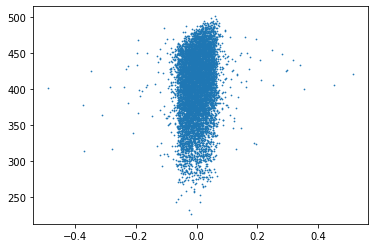

In [40]:
plt.scatter(df_features['T_data_1_1'], df_labels, .5) # plot data on labels

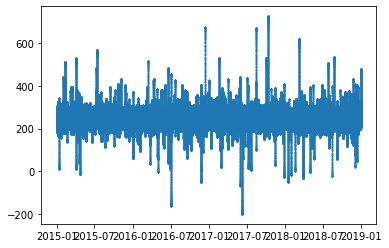

In [41]:
plt.scatter(df_X['date_time'], df_X['T_data_1_1'], .5) # plot sensor data on date_time

### Summarize
... so we dont get lost in variable names
- `df_X`: Orignal X-Data
- `df_Y`: Original Y-Data
- `df_XY`: Merged X- & Y-Data
- `df_features`: Features as Dataframe
- `df_labels`: Labels as Dataframe
- `tens_features`: Features as Tensor
- `tens_labels`: Labels as Tensor

## 2. Read the dataset in batches

In [42]:
def iter_minibatches(features, labels, batch_size: int):
    
    if features.shape[0] != labels.shape[0]: # first, check if X, y have same shape
        raise Exception('Uneven shapes')
    
    indices = np.arange(features.shape[0]) # create array with same lenght as features (0...8511)
    np.random.shuffle(indices) # shuffle those indices (in-place operation)

    for start_index in range(0, features.shape[0], batch_size): # 0 to 8511 with 10 step
        end_index = min(start_index + batch_size, features.shape[0]) # get the end index by using min: (0 + 10, 8512) = 10, ..., (8510 + 10, 8512) = 8512
        shuff_indices = indices[start_index:end_index] # contains shuffled indices in batch-size
        yield features[shuff_indices], labels[shuff_indices] # return shuffled features & labels but remember iter-position

## 3. Model definition (Linear Regression NN)

3.1 compute $\hat{y}$
- Recall: Matrix-Vector dot product
- - $ \mathbf{X}\mathbf{w} $ will produce a **vector**
- - $ b $ is a **scalar**
- - $ \hat{y} $ will be a **vector**
$$\hat{y} = \mathbf{X}\mathbf{w} + b$$

In [43]:
def lin_reg_nn(features, weights, bias):
    return torch.matmul(features, weights) + bias

## 4. Loss function definition (Mean squared error)
4.1 now use $\hat{y}$ to compute the error / loss

$$\mathcal{L} = \frac{1}{n} \sum_{i = 1}^{n} (y^{(i)} - \hat{y}^{(i)})^2$$

In [79]:
def mse_loss(y, y_pred):
    return ((y - y_pred)**2).mean()

## 5. Optimization algorithm (minibatch stochastic gradient descent)
5.1 finally, use an optimization algorithm to adjust weights (-> to lower error)
$$ \mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_w $$

- `parameters`: tensor contains weights, bias which we want to update
- `learning_rate`: determines how *strong* the optimization will be
- `torch.no_grad()`: to keep the update out of the gradient computation
- - Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
- `parameters.grad`: gradient attribute of a tensor -> `torch.Tensor.grad`
- `grad.zero_()`: Tell PyTorch to let it go (the gradient)

In [80]:
def stoch_grad_desc(parameters, learning_rate, batch_size):
    with torch.no_grad():
         for parameter in parameters:
                parameter -= learning_rate * parameter.grad
                parameter.grad.zero_() # in-place operation _

## 6. Training procedure
```{r, tidy=FALSE, eval=FALSE, highlight=FALSE }

for each epoch:
    for each batch:
        calculate loss
        compute gradient
        update parameters
```

6.1 Parameters
- **hyper parameters**: optimized manually
- **model parameters**: optimized (learned) by the model
- - `required_grad=True`: for gradient computation in PyTorch
- - `weights`: The rows of the weight-vector should be equal to the amount of features
- - `bias`: scalar with 0 initialization

In [105]:
# hyper parameters
learning_rate = 0.1
epochs = 600
batch_size = 250

In [106]:
# model parameters
weights = torch.randn(tens_features.shape[1], 1, requires_grad=True, dtype=torch.float32) # mean of 0 and standard deviation of 1
bias = torch.zeros(1, requires_grad=True) # init with 0

6.3 Create training procedure
- `loss.backward()`: computes dloss/dx for every parameter x which has `requires_grad=True`. These are accumulated into `x.grad` for every parameter x. https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944. By default, pytorch expects `backward()` to be called for the last output of the network - the loss function. https://stackoverflow.com/questions/57248777/backward-function-in-pytorch/57249287#57249287. If your loss is not a scalar value, then you should certainly use either `loss.mean()` or `loss.sum()` to convert it to a scalar before calling the backward. Otherwise, it will cause an error. https://discuss.pytorch.org/t/should-i-do-loss-backward-or-loss-mean-backward/35622

In [109]:
for epoch in range(epochs):

    for X, y in iter_minibatches(tens_features, tens_labels, batch_size): 
        y_pred = lin_reg_nn(X, weights, bias) # get prediction
        batch_loss = mse_loss(y, y_pred) # get error/loss
        batch_loss.sum().backward() # sum gradients
       
        #loss.backward() 
        parameters = weights, bias # tuple
        stoch_grad_desc(parameters, learning_rate, batch_size) # update parameters (weights, bias)
        
    print(epoch, batch_loss)

0 tensor(289.5201, grad_fn=<MeanBackward0>)
1 tensor(492.2798, grad_fn=<MeanBackward0>)
2 tensor(294.2101, grad_fn=<MeanBackward0>)
3 tensor(691.1398, grad_fn=<MeanBackward0>)
4 tensor(208.6639, grad_fn=<MeanBackward0>)
5 tensor(621.4995, grad_fn=<MeanBackward0>)
6 tensor(297.5500, grad_fn=<MeanBackward0>)
7 tensor(298.6767, grad_fn=<MeanBackward0>)
8 tensor(246.9465, grad_fn=<MeanBackward0>)
9 tensor(123.1116, grad_fn=<MeanBackward0>)
10 tensor(170.6784, grad_fn=<MeanBackward0>)
11 tensor(578.4990, grad_fn=<MeanBackward0>)
12 tensor(142.4372, grad_fn=<MeanBackward0>)
13 tensor(240.0982, grad_fn=<MeanBackward0>)
14 tensor(1927.1788, grad_fn=<MeanBackward0>)
15 tensor(116.3294, grad_fn=<MeanBackward0>)
16 tensor(900.1817, grad_fn=<MeanBackward0>)
17 tensor(1596.0656, grad_fn=<MeanBackward0>)
18 tensor(481.4765, grad_fn=<MeanBackward0>)
19 tensor(88.5855, grad_fn=<MeanBackward0>)
20 tensor(354.5229, grad_fn=<MeanBackward0>)
21 tensor(631.4119, grad_fn=<MeanBackward0>)
22 tensor(347.7008,

206 tensor(526.3589, grad_fn=<MeanBackward0>)
207 tensor(490.6490, grad_fn=<MeanBackward0>)
208 tensor(410.1557, grad_fn=<MeanBackward0>)
209 tensor(271.9619, grad_fn=<MeanBackward0>)
210 tensor(459.0558, grad_fn=<MeanBackward0>)
211 tensor(189.4727, grad_fn=<MeanBackward0>)
212 tensor(262.8950, grad_fn=<MeanBackward0>)
213 tensor(172.8108, grad_fn=<MeanBackward0>)
214 tensor(623.9744, grad_fn=<MeanBackward0>)
215 tensor(259.4973, grad_fn=<MeanBackward0>)
216 tensor(878.2400, grad_fn=<MeanBackward0>)
217 tensor(166.2591, grad_fn=<MeanBackward0>)
218 tensor(122.3033, grad_fn=<MeanBackward0>)
219 tensor(181.4333, grad_fn=<MeanBackward0>)
220 tensor(497.7354, grad_fn=<MeanBackward0>)
221 tensor(111.3738, grad_fn=<MeanBackward0>)
222 tensor(304.9786, grad_fn=<MeanBackward0>)
223 tensor(195.9750, grad_fn=<MeanBackward0>)
224 tensor(718.3101, grad_fn=<MeanBackward0>)
225 tensor(430.9452, grad_fn=<MeanBackward0>)
226 tensor(253.7356, grad_fn=<MeanBackward0>)
227 tensor(5804.0278, grad_fn=<Mea

406 tensor(535.5306, grad_fn=<MeanBackward0>)
407 tensor(1248.0111, grad_fn=<MeanBackward0>)
408 tensor(412.7713, grad_fn=<MeanBackward0>)
409 tensor(409.2649, grad_fn=<MeanBackward0>)
410 tensor(218.8447, grad_fn=<MeanBackward0>)
411 tensor(124.8651, grad_fn=<MeanBackward0>)
412 tensor(537.5259, grad_fn=<MeanBackward0>)
413 tensor(324.8694, grad_fn=<MeanBackward0>)
414 tensor(365.1073, grad_fn=<MeanBackward0>)
415 tensor(1140.5502, grad_fn=<MeanBackward0>)
416 tensor(720.7127, grad_fn=<MeanBackward0>)
417 tensor(123.9631, grad_fn=<MeanBackward0>)
418 tensor(482.3297, grad_fn=<MeanBackward0>)
419 tensor(575.2474, grad_fn=<MeanBackward0>)
420 tensor(296.1447, grad_fn=<MeanBackward0>)
421 tensor(282.3203, grad_fn=<MeanBackward0>)
422 tensor(494.9668, grad_fn=<MeanBackward0>)
423 tensor(1672.3636, grad_fn=<MeanBackward0>)
424 tensor(739.8819, grad_fn=<MeanBackward0>)
425 tensor(293.5406, grad_fn=<MeanBackward0>)
426 tensor(361.5455, grad_fn=<MeanBackward0>)
427 tensor(178.5927, grad_fn=<M

## 7. Prediction
- make predictions on entire dataset `tens_features`

In [103]:
print("Average loss: ", loss.mean())
for epoch in range(epochs):
    with torch.no_grad():
        y_pred = lin_reg_nn(tens_features, weights, bias)
        train_loss = mse_loss(tens_labels, y_pred)
        
        print("Epoch: ", epoch)
        print("Actual: ", tens_labels[epoch])
        print("Prediction: ", y_pred[epoch], '\n')
        
        

Average loss:  tensor(521.8619)
Epoch:  0
Actual:  tensor([392.])
Prediction:  tensor([351.2428]) 

Epoch:  1
Actual:  tensor([393.])
Prediction:  tensor([402.7527]) 

Epoch:  2
Actual:  tensor([400.])
Prediction:  tensor([401.9369]) 

Epoch:  3
Actual:  tensor([408.])
Prediction:  tensor([409.1056]) 

Epoch:  4
Actual:  tensor([405.])
Prediction:  tensor([388.7175]) 

Epoch:  5
Actual:  tensor([405.])
Prediction:  tensor([391.7756]) 

Epoch:  6
Actual:  tensor([376.])
Prediction:  tensor([264.5985]) 

Epoch:  7
Actual:  tensor([486.])
Prediction:  tensor([489.1084]) 

Epoch:  8
Actual:  tensor([486.])
Prediction:  tensor([484.1139]) 

Epoch:  9
Actual:  tensor([491.])
Prediction:  tensor([501.7232]) 

Epoch:  10
Actual:  tensor([485.])
Prediction:  tensor([477.0412]) 

Epoch:  11
Actual:  tensor([456.])
Prediction:  tensor([431.6746]) 

Epoch:  12
Actual:  tensor([420.])
Prediction:  tensor([424.5817]) 

Epoch:  13
Actual:  tensor([410.])
Prediction:  tensor([421.0554]) 

Epoch:  14
A

Actual:  tensor([378.])
Prediction:  tensor([378.7075]) 

Epoch:  222
Actual:  tensor([380.])
Prediction:  tensor([380.4371]) 

Epoch:  223
Actual:  tensor([383.])
Prediction:  tensor([384.4055]) 

Epoch:  224
Actual:  tensor([460.])
Prediction:  tensor([451.1175]) 

Epoch:  225
Actual:  tensor([419.])
Prediction:  tensor([412.7594]) 

Epoch:  226
Actual:  tensor([378.])
Prediction:  tensor([373.9796]) 

Epoch:  227
Actual:  tensor([351.])
Prediction:  tensor([381.0374]) 

Epoch:  228
Actual:  tensor([395.])
Prediction:  tensor([398.9073]) 

Epoch:  229
Actual:  tensor([432.])
Prediction:  tensor([430.0393]) 

Epoch:  230
Actual:  tensor([452.])
Prediction:  tensor([428.0917]) 

Epoch:  231
Actual:  tensor([449.])
Prediction:  tensor([443.1104]) 

Epoch:  232
Actual:  tensor([448.])
Prediction:  tensor([443.1355]) 

Epoch:  233
Actual:  tensor([458.])
Prediction:  tensor([450.0880]) 

Epoch:  234
Actual:  tensor([472.])
Prediction:  tensor([475.5419]) 

Epoch:  235
Actual:  tensor([476

Actual:  tensor([420.])
Prediction:  tensor([419.0849]) 

Epoch:  462
Actual:  tensor([468.])
Prediction:  tensor([455.6354]) 

Epoch:  463
Actual:  tensor([457.])
Prediction:  tensor([439.7372]) 

Epoch:  464
Actual:  tensor([430.])
Prediction:  tensor([428.7289]) 

Epoch:  465
Actual:  tensor([398.])
Prediction:  tensor([387.3516]) 

Epoch:  466
Actual:  tensor([402.])
Prediction:  tensor([395.3900]) 

Epoch:  467
Actual:  tensor([427.])
Prediction:  tensor([428.2954]) 

Epoch:  468
Actual:  tensor([457.])
Prediction:  tensor([454.3545]) 

Epoch:  469
Actual:  tensor([393.])
Prediction:  tensor([408.1311]) 

Epoch:  470
Actual:  tensor([405.])
Prediction:  tensor([427.1037]) 

Epoch:  471
Actual:  tensor([430.])
Prediction:  tensor([422.1670]) 

Epoch:  472
Actual:  tensor([413.])
Prediction:  tensor([417.8077]) 

Epoch:  473
Actual:  tensor([434.])
Prediction:  tensor([437.6499]) 

Epoch:  474
Actual:  tensor([458.])
Prediction:  tensor([453.8882]) 

Epoch:  475
Actual:  tensor([476

## 8. Conclusion
- This dataset requires a very low learning rate, otherwise the gradients will blow up and become inf / NaN
- - Features probably need to be normalized [-1, 1]
- Prediction looks good compared to the actual values
- - Not sure how to interpret the `loss.mean()` value